<a href="https://colab.research.google.com/github/mind-ctrl/DISFL-QA-Experiments/blob/main/Exp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 2: PEFT LORA with Full Training Dataset - Enhanced

## Important: Avoiding Widget Errors on GitHub

Before downloading this notebook to upload to GitHub:
1. Make sure ALL cells have finished executing completely
2. Wait for all progress bars to show as completed (not in-progress)
3. Check that training cells show final results, not active widgets
4. Then: File → Download → Download .ipynb

This notebook is configured to minimize widget errors:
- Progress bars are configured to be GitHub-friendly
- External logging (wandb/tensorboard) is disabled
- All outputs will be static once cells complete

If you still get widget errors on GitHub:
- Use nbviewer: https://nbviewer.org/github/YOUR_USERNAME/YOUR_REPO/blob/main/YOUR_NOTEBOOK.ipynb
- Or convert to HTML: jupyter nbconvert --to html notebook.ipynb

---

## Objective
This experiment is designed to rigorously assess the performance of a state-of-the-art language model utilizing Parameter-Efficient Fine-Tuning (PEFT) with LORA (Low-Rank Adaptation). The principal aim is to evaluate the efficacy and adaptation capabilities of the fine-tuned model when applied to the full training dataset.

This enhanced version extends the original experiment with:

- Validation during training for better monitoring
- Comprehensive evaluation on both dev and test sets
- Extended metrics (BLEU, ROUGE, WER, CER, Exact Match)
- Qualitative error analysis with detailed failure case examination
- Timing and efficiency metrics throughout the pipeline
- Modular code structure for better maintainability
- Enhanced visualizations including error categorization

## Experimental Setup

### Model Specifications
- **Architecture:** Meta's Llama 3.1 8B
- **Source:** Unsloth HuggingFace model repository

### Computational Environment
- **Platform:** Google Colab Notebook
- **Infrastructure Tier:** Colab Pro
- **GPU Specification:** NVIDIA Tesla A100

### Dataset
- **Corpus:** google-research-datasets/Disfl-QA
- **Training Set:** 7,182 rows
- **Dev Set:** 1,000 rows (used for validation)
- **Test Set:** 3,643 rows (used for final evaluation)

### LORA Configuration
- **Rank (r):** 16
- **Alpha:** 16
- **Dropout:** 0
- **Target modules:** q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj

## Step 1: Installing required dependencies.

In [5]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install evaluate rouge_score jiwer

from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

Step 2: Load Data

In [6]:
import requests
import pandas as pd
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from datasets import Dataset
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback
import evaluate
from jiwer import wer, cer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


#Step 3 COnfiguration and Hyperparameters

In [7]:
# Hyperparameter configuration
CONFIG = {
    # Model config
    'model_name': 'unsloth/Meta-Llama-3.1-8B',
    'max_seq_length': 2048,
    'dtype': None,
    'load_in_4bit': True,

    # LORA config
    'lora_r': 16,
    'lora_alpha': 16,
    'lora_dropout': 0,

    # Training config
    'per_device_train_batch_size': 32,
    'per_device_eval_batch_size': 32,
    'gradient_accumulation_steps': 4,
    'warmup_steps': 5,
    'num_train_epochs': 1,
    'learning_rate': 2e-4,
    'weight_decay': 0.01,
    'logging_steps': 1,
    'eval_steps': 10,
    'save_steps': 20,
    'seed': 3407,

    # Dataset config
    'use_full_training_set': True,
    'max_new_tokens': 64,
}

# Save config for reproducibility
print("Experiment Configuration:")
print(json.dumps(CONFIG, indent=2))

# Track experiment start time
experiment_start_time = time.time()
print(f"\nExperiment started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Experiment Configuration:
{
  "model_name": "unsloth/Meta-Llama-3.1-8B",
  "max_seq_length": 2048,
  "dtype": null,
  "load_in_4bit": true,
  "lora_r": 16,
  "lora_alpha": 16,
  "lora_dropout": 0,
  "per_device_train_batch_size": 32,
  "per_device_eval_batch_size": 32,
  "gradient_accumulation_steps": 4,
  "warmup_steps": 5,
  "num_train_epochs": 1,
  "learning_rate": 0.0002,
  "weight_decay": 0.01,
  "logging_steps": 1,
  "eval_steps": 10,
  "save_steps": 20,
  "seed": 3407,
  "use_full_training_set": true,
  "max_new_tokens": 64
}

Experiment started at: 2025-11-11 06:47:08


Step 4: Load and Prepare Data

In [8]:
def process_github_json_files(base_url, file_names):
    """Download and process JSON files from GitHub repository."""
    dataframes = {}

    for file_name in file_names:
        url = f"{base_url}/{file_name}"
        try:
            print(f"Downloading {file_name}...")
            response = requests.get(url)
            if response.status_code != 200:
                raise Exception(f"Failed to download {file_name}. Status code: {response.status_code}")

            data = json.loads(response.text)
            df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'id'})

            output_file = f"{file_name}"
            df.to_json(output_file, orient='records')

            key = file_name.split('.')[0]
            dataframes[key] = df
            print(f"  [Success] {file_name} loaded: {len(df)} rows")

        except Exception as e:
            print(f"  [Error] Error processing {file_name}: {str(e)}")

    return dataframes.get('train'), dataframes.get('test'), dataframes.get('dev')

# Load datasets
base_url = "https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/master"
file_names = ["train.json", "test.json", "dev.json"]

data_load_start = time.time()
df_train, df_test, df_dev = process_github_json_files(base_url, file_names)
data_load_time = time.time() - data_load_start

print(f"\nData loading completed in {data_load_time:.2f} seconds")
print(f"\nDataset Summary:")
print(f"  Training set: {df_train.shape if df_train is not None else 'Not available'}")
print(f"  Test set: {df_test.shape if df_test is not None else 'Not available'}")
print(f"  Dev set: {df_dev.shape if df_dev is not None else 'Not available'}")

  [Success] train.json loaded: 7182 rows
  [Success] test.json loaded: 3643 rows
  [Success] dev.json loaded: 1000 rows

Data loading completed in 0.70 seconds

Dataset Summary:
  Training set: (7182, 3)
  Test set: (3643, 3)
  Dev set: (1000, 3)


In [9]:
# Display sample data
print("Sample Training Data:")
df_train.head(5)

Sample Training Data:


,id,original,disfluent
0,5a5918ff3e1742001a15cf7e,What do unstable isotope studies indicate?,What do petrologists no what do unstable isoto...
1,5ad4f40c5b96ef001a10a774,What is the basic unit of territorial division...,What is the second level of territorial divisi...
2,572684365951b619008f7543,Which genus lack tentacles and sheaths?,Juvenile platyctenids no wow Which genus lack ...
3,5729f799af94a219006aa70a,Long-lived memory cells can remember previous ...,When a pathogen is met again scratch that I me...
4,5ad3b9cd604f3c001a3fee87,What led to Newcastle's rise to power as milit...,What led to the Duke of Cumberland's rise to p...


Step 5: Load Base Model

In [10]:
model_load_start = time.time()

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=CONFIG['model_name'],
    max_seq_length=CONFIG['max_seq_length'],
    dtype=CONFIG['dtype'],
    load_in_4bit=CONFIG['load_in_4bit'],
)

model_load_time = time.time() - model_load_start
print(f"\nModel loaded in {model_load_time:.2f} seconds")

==((====))==  Unsloth 2025.11.3: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]


Model loaded in 102.26 seconds


Step 6: Prepare Training and Validation Datasets

In [11]:
# Define prompt templates
instruction_template = """
You are an AI assistant that corrects disfluent questions.
Remove all disfluencies (filler words, false starts, hesitations, repetitions) and output a single, fluent, clear, and concise version of the input question.
Maintain the original meaning and intent. Use natural, formal English.
Do not change the subject, alter the question's meaning, or add any new information.
Provide only the corrected question as a single line, without explanations, examples, or additional formatting.
"""

prompt_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(df, num_rows=None):
    """Format data for training/validation."""
    if num_rows:
        df_subset = df.head(num_rows)
    else:
        df_subset = df

    num_samples = len(df_subset)
    instructions = [instruction_template] * num_samples
    inputs = df_subset['disfluent'].tolist()
    outputs = df_subset['original'].tolist()

    texts = []
    for instruction, input_text, output_text in zip(instructions, inputs, outputs):
        text = prompt_template.format(instruction, input_text, output_text) + EOS_TOKEN
        texts.append(text)

    return {
        "instruction": instructions,
        "input": inputs,
        "output": outputs,
        "text": texts
    }

# Prepare training dataset
TRAINING_ROWS = len(df_train) if CONFIG['use_full_training_set'] else 100
formatted_train_data = formatting_prompts_func(df_train, TRAINING_ROWS)
train_dataset = Dataset.from_dict(formatted_train_data)

# Prepare validation dataset (use dev set)
formatted_dev_data = formatting_prompts_func(df_dev)
eval_dataset = Dataset.from_dict(formatted_dev_data)

print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(eval_dataset)} samples")
print(f"\nDataset features: {train_dataset.features}")

Training dataset: 7182 samples
Validation dataset: 1000 samples

Dataset features: {'instruction': Value('string'), 'input': Value('string'), 'output': Value('string'), 'text': Value('string')}


Step 7: Configure PEFT Model wth LoRA

In [12]:
model = FastLanguageModel.get_peft_model(
    model,
    r=CONFIG['lora_r'],
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=CONFIG['lora_alpha'],
    lora_dropout=CONFIG['lora_dropout'],
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=CONFIG['seed'],
    use_rslora=False,
    loftq_config=None,
)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_percentage = 100 * trainable_params / total_params

print(f"\nModel Parameters:")
print(f"  Trainable: {trainable_params:,} ({trainable_percentage:.2f}%)")
print(f"  Total: {total_params:,}")

Unsloth 2025.11.3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.



Model Parameters:
  Trainable: 41,943,040 (0.90%)
  Total: 4,670,623,744


Step 8: Setup Trainer with Validation

In [13]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Added validation set
    dataset_text_field="text",
    max_seq_length=CONFIG['max_seq_length'],
    dataset_num_proc=2,
    packing=False,
    args=TrainingArguments(
        per_device_train_batch_size=CONFIG['per_device_train_batch_size'],
        per_device_eval_batch_size=CONFIG['per_device_eval_batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        warmup_steps=CONFIG['warmup_steps'],
        num_train_epochs=CONFIG['num_train_epochs'],
        learning_rate=CONFIG['learning_rate'],
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=CONFIG['logging_steps'],
        eval_strategy="steps",  # Enable validation during training
        eval_steps=CONFIG['eval_steps'],
        save_strategy="steps",
        save_steps=CONFIG['save_steps'],
        optim="adamw_8bit",
        weight_decay=CONFIG['weight_decay'],
        lr_scheduler_type="linear",
        seed=CONFIG['seed'],
        output_dir="outputs",
        load_best_model_at_end=True,  # Load best model based on validation
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        report_to=[],  # Disable wandb/tensorboard to avoid widget errors on GitHub
    ),
)

print("Trainer configured successfully with validation enabled!")
print("Note: External logging disabled to prevent widget rendering issues on GitHub")

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/7182 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1000 [00:00<?, ? examples/s]

Trainer configured successfully with validation enabled!
Note: External logging disabled to prevent widget rendering issues on GitHub


Step 9: Train Model

In [14]:
# Check GPU memory before training
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU: {gpu_stats.name}")
print(f"Max memory: {max_memory} GB")
print(f"Reserved memory: {start_gpu_memory} GB\n")

# Train model
training_start = time.time()
print("Starting training...\n")
trainer_stats = trainer.train()
training_time = time.time() - training_start

# Check GPU memory after training
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_training = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)

print(f"\n{'='*60}")
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"Peak GPU memory usage: {used_memory} GB ({used_percentage}%)")
print(f"Additional memory for training: {used_memory_for_training} GB")
print(f"Final training loss: {trainer_stats.training_loss:.4f}")
print(f"{'='*60}")

The model is already on multiple devices. Skipping the move to device specified in `args`.


GPU: Tesla T4
Max memory: 14.741 GB
Reserved memory: 6.881 GB

Starting training...



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,182 | Num Epochs = 1 | Total steps = 57
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 4 x 1) = 128
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,0.756700,0.649457
20,0.522500,0.483549
30,0.429700,0.418192
40,0.425700,0.403508
50,0.404500,0.396979


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient



Training completed in 4357.15 seconds (72.62 minutes)
Peak GPU memory usage: 13.633 GB (92.484%)
Additional memory for training: 6.752 GB
Final training loss: 0.7067


Step 10: Anayze Training Metrics

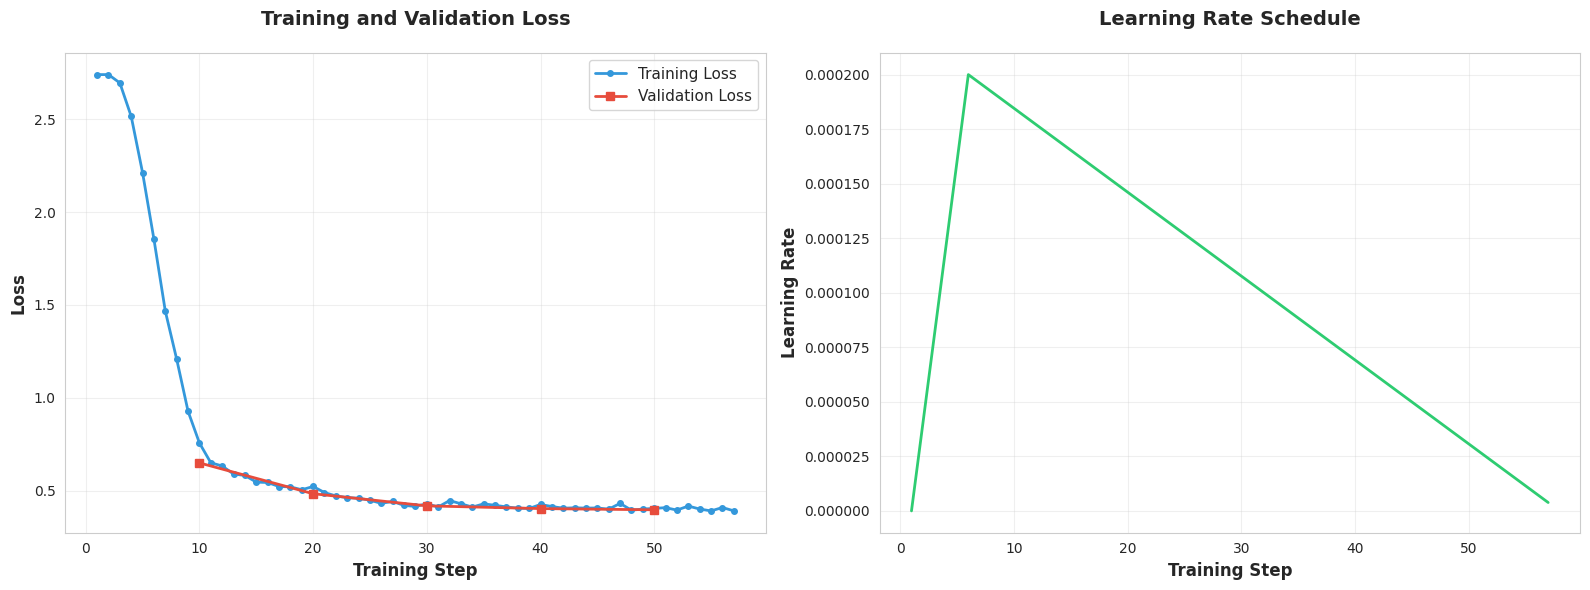


Training Statistics:
  Final Training Loss: 0.3913
  Final Validation Loss: 0.3970
  Best Validation Loss: 0.3970
  Total Training Steps: 57
  Validation Evaluations: 5


In [16]:
# Extract training and validation losses
log_history = trainer.state.log_history  # Fixed: access from trainer.state, not trainer_stats

train_losses = []
train_steps = []
eval_losses = []
eval_steps = []

for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        eval_steps.append(log['step'])

# Plot training and validation curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training loss
ax1.plot(train_steps, train_losses, marker='o', linewidth=2, markersize=4, color='#3498db', label='Training Loss')
if eval_losses:
    ax1.plot(eval_steps, eval_losses, marker='s', linewidth=2, markersize=6, color='#e74c3c', label='Validation Loss')
ax1.set_xlabel('Training Step', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Learning rate schedule
learning_rates = [log['learning_rate'] for log in log_history if 'learning_rate' in log]
lr_steps = [log['step'] for log in log_history if 'learning_rate' in log]
if learning_rates:
    ax2.plot(lr_steps, learning_rates, linewidth=2, color='#2ecc71')
    ax2.set_xlabel('Training Step', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
    ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Statistics:")
print(f"  Final Training Loss: {train_losses[-1]:.4f}")
if eval_losses:
    print(f"  Final Validation Loss: {eval_losses[-1]:.4f}")
    print(f"  Best Validation Loss: {min(eval_losses):.4f}")
print(f"  Total Training Steps: {len(train_losses)}")
print(f"  Validation Evaluations: {len(eval_losses)}")

Step 11: Inference Helper Functions

In [17]:
def generate_prediction(disfluent_input, model, tokenizer, max_new_tokens=64):
    """Generate a single prediction."""
    inputs = tokenizer(
        [prompt_template.format(instruction_template, disfluent_input, "")],
        return_tensors="pt"
    ).to("cuda")

    output_tokens = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id
    )

    output_text = tokenizer.batch_decode(
        output_tokens[:, len(inputs[0].tokens):],
        skip_special_tokens=True
    )[0].replace('\n', ' ').strip()

    return output_text

def batch_inference(df, model, tokenizer, dataset_name="Dataset", max_new_tokens=64):
    """Run inference on entire dataset with timing."""
    print(f"Running inference on {dataset_name} ({len(df)} samples)...")

    # Set model to inference mode
    FastLanguageModel.for_inference(model)

    start_time = time.time()
    predictions = []

    for idx, disfluent in enumerate(df['disfluent']):
        pred = generate_prediction(disfluent, model, tokenizer, max_new_tokens)
        predictions.append(pred)

        if (idx + 1) % 100 == 0:
            elapsed = time.time() - start_time
            avg_time = elapsed / (idx + 1)
            remaining = avg_time * (len(df) - idx - 1)
            print(f"  Progress: {idx+1}/{len(df)} - Avg: {avg_time:.3f}s/sample - ETA: {remaining:.1f}s")

    inference_time = time.time() - start_time
    avg_time_per_sample = inference_time / len(df)

    print(f"  Inference completed in {inference_time:.2f}s")
    print(f"  Average: {avg_time_per_sample:.3f}s per sample")
    print(f"  Throughput: {len(df)/inference_time:.2f} samples/second\n")

    return predictions, inference_time

print("Inference helper functions defined!")

Inference helper functions defined!


Step 12: Evaluate on Dev Set

In [18]:
# Run inference on dev set
df_dev_eval = df_dev.copy()
dev_predictions, dev_inference_time = batch_inference(df_dev_eval, model, tokenizer, "Dev Set", CONFIG['max_new_tokens'])
df_dev_eval['prediction'] = dev_predictions

# Display sample predictions
print("Sample Predictions (Dev Set):")
df_dev_eval[['original', 'disfluent', 'prediction']].head(10)

Running inference on Dev Set (1000 samples)...
  Progress: 100/1000 - Avg: 1.144s/sample - ETA: 1029.4s
  Progress: 200/1000 - Avg: 1.138s/sample - ETA: 910.4s
  Progress: 300/1000 - Avg: 1.152s/sample - ETA: 806.1s
  Progress: 400/1000 - Avg: 1.154s/sample - ETA: 692.3s
  Progress: 500/1000 - Avg: 1.150s/sample - ETA: 575.0s
  Progress: 600/1000 - Avg: 1.150s/sample - ETA: 460.1s
  Progress: 700/1000 - Avg: 1.150s/sample - ETA: 345.0s
  Progress: 800/1000 - Avg: 1.148s/sample - ETA: 229.6s
  Progress: 900/1000 - Avg: 1.150s/sample - ETA: 115.0s
  Progress: 1000/1000 - Avg: 1.156s/sample - ETA: 0.0s
  Inference completed in 1155.64s
  Average: 1.156s per sample
  Throughput: 0.87 samples/second

Sample Predictions (Dev Set):


,original,disfluent,prediction
0,What did the government want Thoreau to do?,Who did no What did the government want Thorea...,What did the government want Thoreau to do?
1,What makes the Wells Fargo Center stand out?,What makes the Bank of America Tower or wait t...,What makes the Wells Fargo Center stand out?
2,What was the Colonia Agrippina's original name?,What was the Colonia Agrippina's original empi...,What was the Colonia Agrippina's original name?
3,Extended networking benefits helped those that...,"Extended authorization limitations, no sorry n...",Extended authorization limitations helped thos...
4,Who is the emphasis on when there is a private...,What is the no make that who is the emphasis o...,Who is the emphasis on when there is a private...
5,What dynasties inspired the Chinese-like eleme...,What dynasties reflected no inspired the Chine...,What dynasties inspired the Chinese-like eleme...
6,What is the density of all primes compatible w...,What is the density of all primes compatible w...,What is the density of all primes compatible w...
7,What did European empires rely on to supply th...,When or uh what did European empires rely on t...,What did European empires rely on to supply th...
8,What did Karlen and Singer present to the US s...,What did Wahl and Ammann no no Karlen and Sing...,What did Karlen and Singer present to the US s...
9,What is the current status of the Haensch study?,What is the current status of Schuenemann's st...,What is the current status of the Haensch study?


Step 13: Evaluate on Test Set

In [19]:
# Run inference on test set
df_test_eval = df_test.copy()
test_predictions, test_inference_time = batch_inference(df_test_eval, model, tokenizer, "Test Set", CONFIG['max_new_tokens'])
df_test_eval['prediction'] = test_predictions

# Display sample predictions
print("Sample Predictions (Test Set):")
df_test_eval[['original', 'disfluent', 'prediction']].head(10)

Running inference on Test Set (3643 samples)...
  Progress: 100/3643 - Avg: 1.034s/sample - ETA: 3664.8s
  Progress: 200/3643 - Avg: 1.044s/sample - ETA: 3595.1s
  Progress: 300/3643 - Avg: 1.134s/sample - ETA: 3791.6s
  Progress: 400/3643 - Avg: 1.193s/sample - ETA: 3870.3s
  Progress: 500/3643 - Avg: 1.216s/sample - ETA: 3823.0s
  Progress: 600/3643 - Avg: 1.256s/sample - ETA: 3821.5s
  Progress: 700/3643 - Avg: 1.262s/sample - ETA: 3713.3s
  Progress: 800/3643 - Avg: 1.259s/sample - ETA: 3578.1s
  Progress: 900/3643 - Avg: 1.251s/sample - ETA: 3430.3s
  Progress: 1000/3643 - Avg: 1.238s/sample - ETA: 3272.4s
  Progress: 1100/3643 - Avg: 1.240s/sample - ETA: 3152.3s
  Progress: 1200/3643 - Avg: 1.230s/sample - ETA: 3005.5s
  Progress: 1300/3643 - Avg: 1.213s/sample - ETA: 2842.0s
  Progress: 1400/3643 - Avg: 1.206s/sample - ETA: 2704.0s
  Progress: 1500/3643 - Avg: 1.204s/sample - ETA: 2580.5s
  Progress: 1600/3643 - Avg: 1.203s/sample - ETA: 2458.1s
  Progress: 1700/3643 - Avg: 1.20

,original,disfluent,prediction
0,In what country is Normandy located?,In what country is Norse found no wait Normand...,In what country is Normandy found?
1,When were the Normans in Normandy?,From which countries no tell me when were the ...,When were the Normans in Normandy?
2,From which countries did the Norse originate?,From which Norse leader I mean countries did t...,From which countries did the Norse originate?
3,Who was the Norse leader?,When I mean Who was the Norse leader?,Who was the Norse leader?
4,What century did the Normans first gain their ...,When no what century did the Normans first gai...,What century did the Normans first gain their ...
5,Who gave their name to Normandy in the 1000's ...,Who gave their name to Frankish in the 1000's ...,Who gave their name to Normandy in the 1000's ...
6,What is France a region of?,What is Denmark a region of uh no France?,What is France a region of?
7,Who did King Charles III swear fealty to?,Who did King Rollo or instead uh Charles III s...,Who did King Charles III swear fealty to?
8,When did the Frankish identity emerge?,When did Norman identity or make that Frankish...,When did Frankish identity emerge?
9,Who was the duke in the battle of Hastings?,Who was the duke in the Kingdom of Sicily sorr...,Who was the duke in the battle of Hastings?


Step 14: Compute Comprehensive Metrics

In [20]:
def compute_all_metrics(df, dataset_name="Dataset"):
    """Compute comprehensive evaluation metrics."""
    print(f"Computing metrics for {dataset_name}...")

    originals = list(df['original'])
    predictions = list(df['prediction'])

    # BLEU Score
    bleu = evaluate.load("bleu")
    bleu_results = bleu.compute(predictions=predictions, references=originals)

    # ROUGE Scores
    rouge = evaluate.load('rouge')
    rouge_results = rouge.compute(predictions=predictions, references=originals)

    # Exact Match
    df['exact_match'] = df['original'] == df['prediction']
    exact_match_rate = df['exact_match'].mean()

    # Word Error Rate (WER)
    wer_score = wer(originals, predictions)

    # Character Error Rate (CER)
    cer_score = cer(originals, predictions)

    # Length statistics
    df['orig_len'] = df['original'].str.split().str.len()
    df['pred_len'] = df['prediction'].str.split().str.len()
    df['len_diff'] = abs(df['orig_len'] - df['pred_len'])

    metrics = {
        'bleu': bleu_results['bleu'],
        'rouge1': rouge_results['rouge1'],
        'rouge2': rouge_results['rouge2'],
        'rougeL': rouge_results['rougeL'],
        'exact_match': exact_match_rate,
        'wer': wer_score,
        'cer': cer_score,
        'avg_length_diff': df['len_diff'].mean(),
    }

    print(f"\n{dataset_name} Metrics:")
    print(f"  BLEU Score: {metrics['bleu']:.4f}")
    print(f"  ROUGE-1: {metrics['rouge1']:.4f}")
    print(f"  ROUGE-2: {metrics['rouge2']:.4f}")
    print(f"  ROUGE-L: {metrics['rougeL']:.4f}")
    print(f"  Exact Match: {metrics['exact_match']:.4f} ({int(metrics['exact_match']*len(df))}/{len(df)})")
    print(f"  Word Error Rate: {metrics['wer']:.4f}")
    print(f"  Character Error Rate: {metrics['cer']:.4f}")
    print(f"  Avg Length Difference: {metrics['avg_length_diff']:.2f} words\n")

    return metrics, df

# Compute metrics for both datasets
dev_metrics, df_dev_eval = compute_all_metrics(df_dev_eval, "Dev Set")
test_metrics, df_test_eval = compute_all_metrics(df_test_eval, "Test Set")

Computing metrics for Dev Set...



Dev Set Metrics:
  BLEU Score: 0.8785
  ROUGE-1: 0.9455
  ROUGE-2: 0.9028
  ROUGE-L: 0.9354
  Exact Match: 0.6250 (625/1000)
  Word Error Rate: 0.1174
  Character Error Rate: 0.0899
  Avg Length Difference: 0.57 words

Computing metrics for Test Set...

Test Set Metrics:
  BLEU Score: 0.8704
  ROUGE-1: 0.9427
  ROUGE-2: 0.8966
  ROUGE-L: 0.9314
  Exact Match: 0.6302 (2296/3643)
  Word Error Rate: 0.1237
  Character Error Rate: 0.0943
  Avg Length Difference: 0.62 words



## Step 15: Metrics Comparison Visualization

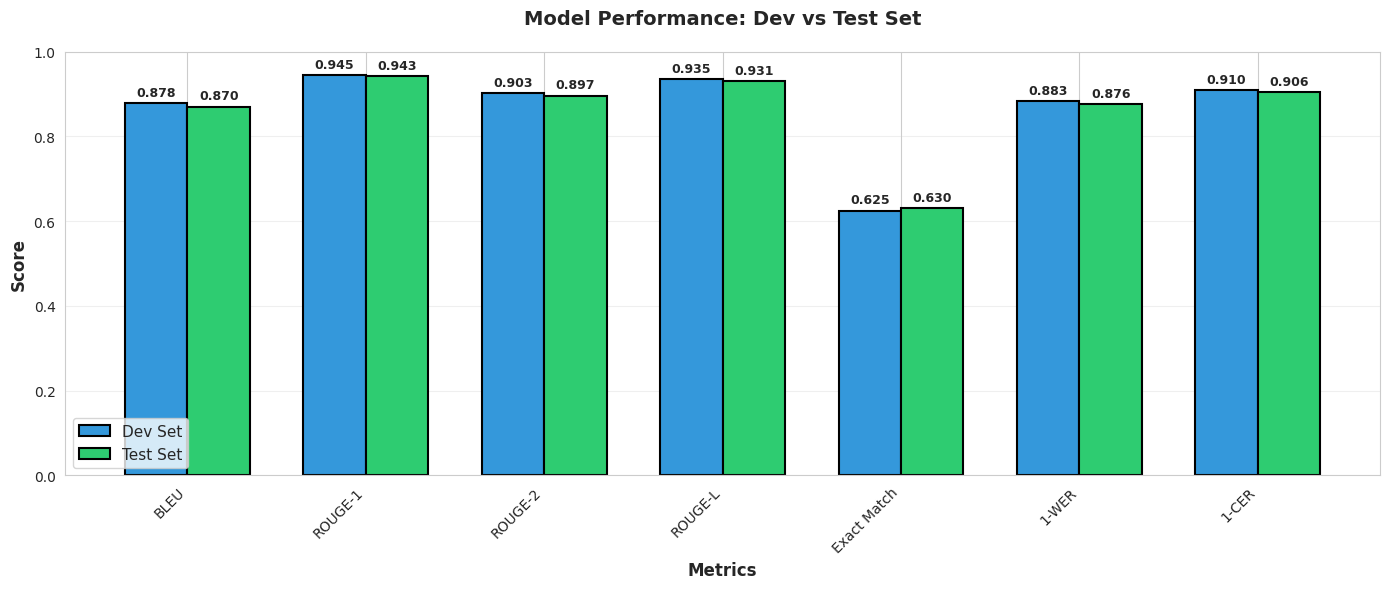

In [21]:
# Compare metrics across datasets
metric_names = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Exact Match', '1-WER', '1-CER']
dev_scores = [
    dev_metrics['bleu'],
    dev_metrics['rouge1'],
    dev_metrics['rouge2'],
    dev_metrics['rougeL'],
    dev_metrics['exact_match'],
    1 - dev_metrics['wer'],  # Invert WER for better visualization
    1 - dev_metrics['cer'],  # Invert CER for better visualization
]
test_scores = [
    test_metrics['bleu'],
    test_metrics['rouge1'],
    test_metrics['rouge2'],
    test_metrics['rougeL'],
    test_metrics['exact_match'],
    1 - test_metrics['wer'],
    1 - test_metrics['cer'],
]

x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, dev_scores, width, label='Dev Set', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test Set', color='#2ecc71', edgecolor='black', linewidth=1.5)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Dev vs Test Set', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()

## Step 16: Qualitative Error Analysis

In [22]:
def analyze_errors(df, dataset_name="Dataset", num_examples=20):
    """Detailed error analysis with examples."""
    print(f"\n{'='*80}")
    print(f"Error Analysis for {dataset_name}")
    print(f"{'='*80}\n")

    failures = df[~df['exact_match']].copy()
    successes = df[df['exact_match']].copy()

    print(f"Total Samples: {len(df)}")
    print(f"Perfect Matches: {len(successes)} ({len(successes)/len(df)*100:.2f}%)")
    print(f"Failures: {len(failures)} ({len(failures)/len(df)*100:.2f}%)\n")

    if len(failures) == 0:
        print("No failures - Perfect accuracy!")
        return

    # Categorize errors by length difference
    failures['error_category'] = pd.cut(
        failures['len_diff'],
        bins=[-1, 0, 2, 5, 100],
        labels=['Exact Length', 'Minor (1-2 words)', 'Moderate (3-5 words)', 'Major (6+ words)']
    )

    print("Error Distribution by Magnitude:")
    error_dist = failures['error_category'].value_counts().sort_index()
    for category, count in error_dist.items():
        print(f"  {category}: {count} ({count/len(failures)*100:.1f}%)")

    # Show worst failures
    print(f"\n\nTop {min(num_examples, len(failures))} Failure Cases (sorted by length difference):\n")
    worst_failures = failures.nlargest(num_examples, 'len_diff')

    for idx, row in worst_failures.iterrows():
        print(f"Example {idx+1}:")
        print(f"  Disfluent:  {row['disfluent']}")
        print(f"  Expected:   {row['original']}")
        print(f"  Predicted:  {row['prediction']}")
        print(f"  Length Diff: {int(row['len_diff'])} words")
        print(f"  Orig Length: {int(row['orig_len'])} words, Pred Length: {int(row['pred_len'])} words")
        print("-" * 80)

    # Show some perfect matches for comparison
    print(f"\n\nSample Perfect Matches (for comparison):\n")
    sample_successes = successes.sample(min(5, len(successes)))

    for idx, row in sample_successes.iterrows():
        print(f"Example:")
        print(f"  Disfluent:  {row['disfluent']}")
        print(f"  Corrected:  {row['prediction']}")
        print("-" * 80)

# Analyze errors for both datasets
analyze_errors(df_dev_eval, "Dev Set", num_examples=15)
analyze_errors(df_test_eval, "Test Set", num_examples=15)


Error Analysis for Dev Set

Total Samples: 1000
Perfect Matches: 625 (62.50%)
Failures: 375 (37.50%)

Error Distribution by Magnitude:
  Exact Length: 137 (36.5%)
  Minor (1-2 words): 165 (44.0%)
  Moderate (3-5 words): 57 (15.2%)
  Major (6+ words): 16 (4.3%)


Top 15 Failure Cases (sorted by length difference):

Example 631:
  Disfluent:  #VALUE!
  Expected:   WHy was the Merit network formed in Michigan 
  Predicted:  What is the percentage of no longer than 30 years that a person can be expected to remain in the workforce?
  Length Diff: 13 words
  Orig Length: 8 words, Pred Length: 21 words
--------------------------------------------------------------------------------
Example 587:
  Disfluent:  Assuming the Air Force charged actually paid for the development of the concept, then would the Air Force be entitled to a royalty fee for every packet sent?
  Expected:   Assuming the Air Force paid for the development of the concept, then would the Air Force be entitled to a royalty fe

## Step 17: Error Distribution Visualizations

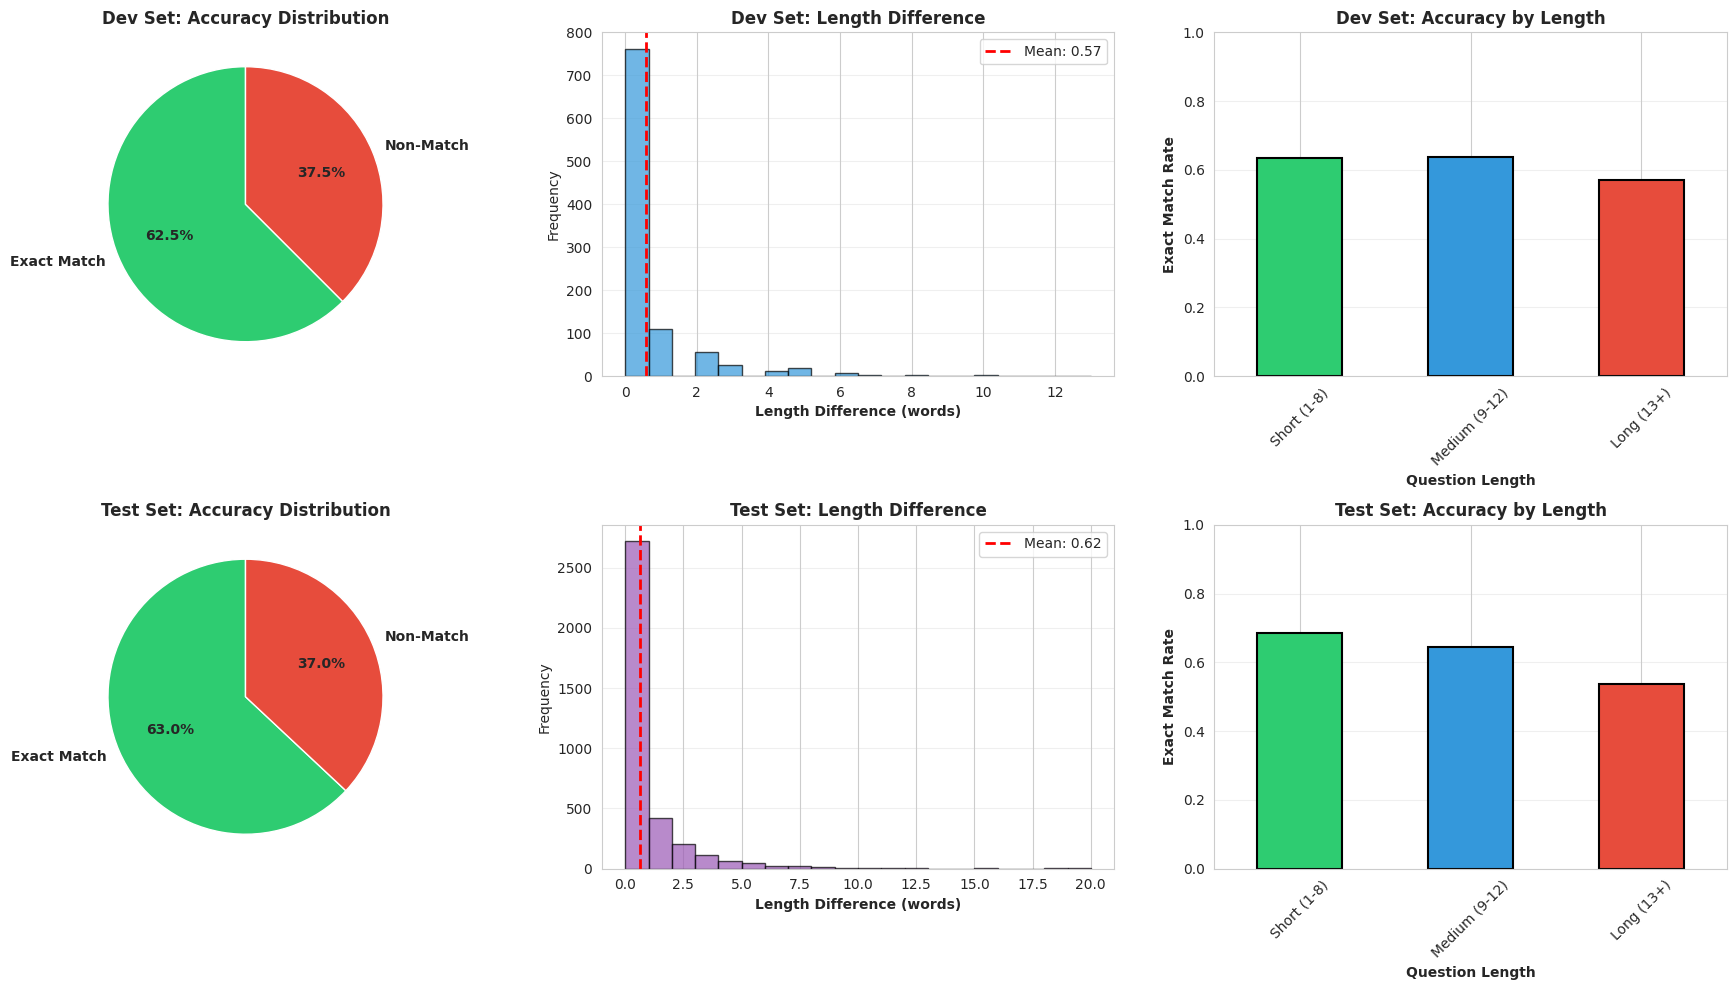

In [23]:
def visualize_error_distributions(df_dev, df_test):
    """Visualize error patterns across datasets."""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Dev Set Visualizations
    # 1. Accuracy pie chart
    dev_match_counts = df_dev['exact_match'].value_counts()
    colors = ['#2ecc71', '#e74c3c']
    axes[0, 0].pie(dev_match_counts.values, labels=['Exact Match', 'Non-Match'],
                   autopct='%1.1f%%', startangle=90, colors=colors,
                   textprops={'fontsize': 10, 'fontweight': 'bold'})
    axes[0, 0].set_title('Dev Set: Accuracy Distribution', fontsize=12, fontweight='bold')

    # 2. Length difference distribution
    axes[0, 1].hist(df_dev['len_diff'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(df_dev['len_diff'].mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {df_dev["len_diff"].mean():.2f}')
    axes[0, 1].set_xlabel('Length Difference (words)', fontsize=10, fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontsize=10)
    axes[0, 1].set_title('Dev Set: Length Difference', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    # 3. Accuracy by question length
    df_dev['length_cat'] = pd.cut(df_dev['orig_len'], bins=[0, 8, 12, 100],
                                   labels=['Short (1-8)', 'Medium (9-12)', 'Long (13+)'])
    dev_acc_by_len = df_dev.groupby('length_cat')['exact_match'].mean()
    dev_acc_by_len.plot(kind='bar', ax=axes[0, 2], color=['#2ecc71', '#3498db', '#e74c3c'],
                        edgecolor='black', linewidth=1.5)
    axes[0, 2].set_ylabel('Exact Match Rate', fontsize=10, fontweight='bold')
    axes[0, 2].set_xlabel('Question Length', fontsize=10, fontweight='bold')
    axes[0, 2].set_title('Dev Set: Accuracy by Length', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylim(0, 1.0)
    axes[0, 2].grid(axis='y', alpha=0.3)
    axes[0, 2].tick_params(axis='x', rotation=45)

    # Test Set Visualizations
    # 4. Accuracy pie chart
    test_match_counts = df_test['exact_match'].value_counts()
    axes[1, 0].pie(test_match_counts.values, labels=['Exact Match', 'Non-Match'],
                   autopct='%1.1f%%', startangle=90, colors=colors,
                   textprops={'fontsize': 10, 'fontweight': 'bold'})
    axes[1, 0].set_title('Test Set: Accuracy Distribution', fontsize=12, fontweight='bold')

    # 5. Length difference distribution
    axes[1, 1].hist(df_test['len_diff'], bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(df_test['len_diff'].mean(), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {df_test["len_diff"].mean():.2f}')
    axes[1, 1].set_xlabel('Length Difference (words)', fontsize=10, fontweight='bold')
    axes[1, 1].set_ylabel('Frequency', fontsize=10)
    axes[1, 1].set_title('Test Set: Length Difference', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    # 6. Accuracy by question length
    df_test['length_cat'] = pd.cut(df_test['orig_len'], bins=[0, 8, 12, 100],
                                    labels=['Short (1-8)', 'Medium (9-12)', 'Long (13+)'])
    test_acc_by_len = df_test.groupby('length_cat')['exact_match'].mean()
    test_acc_by_len.plot(kind='bar', ax=axes[1, 2], color=['#2ecc71', '#3498db', '#e74c3c'],
                         edgecolor='black', linewidth=1.5)
    axes[1, 2].set_ylabel('Exact Match Rate', fontsize=10, fontweight='bold')
    axes[1, 2].set_xlabel('Question Length', fontsize=10, fontweight='bold')
    axes[1, 2].set_title('Test Set: Accuracy by Length', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylim(0, 1.0)
    axes[1, 2].grid(axis='y', alpha=0.3)
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

visualize_error_distributions(df_dev_eval, df_test_eval)

## Step 18: Word Length Analysis

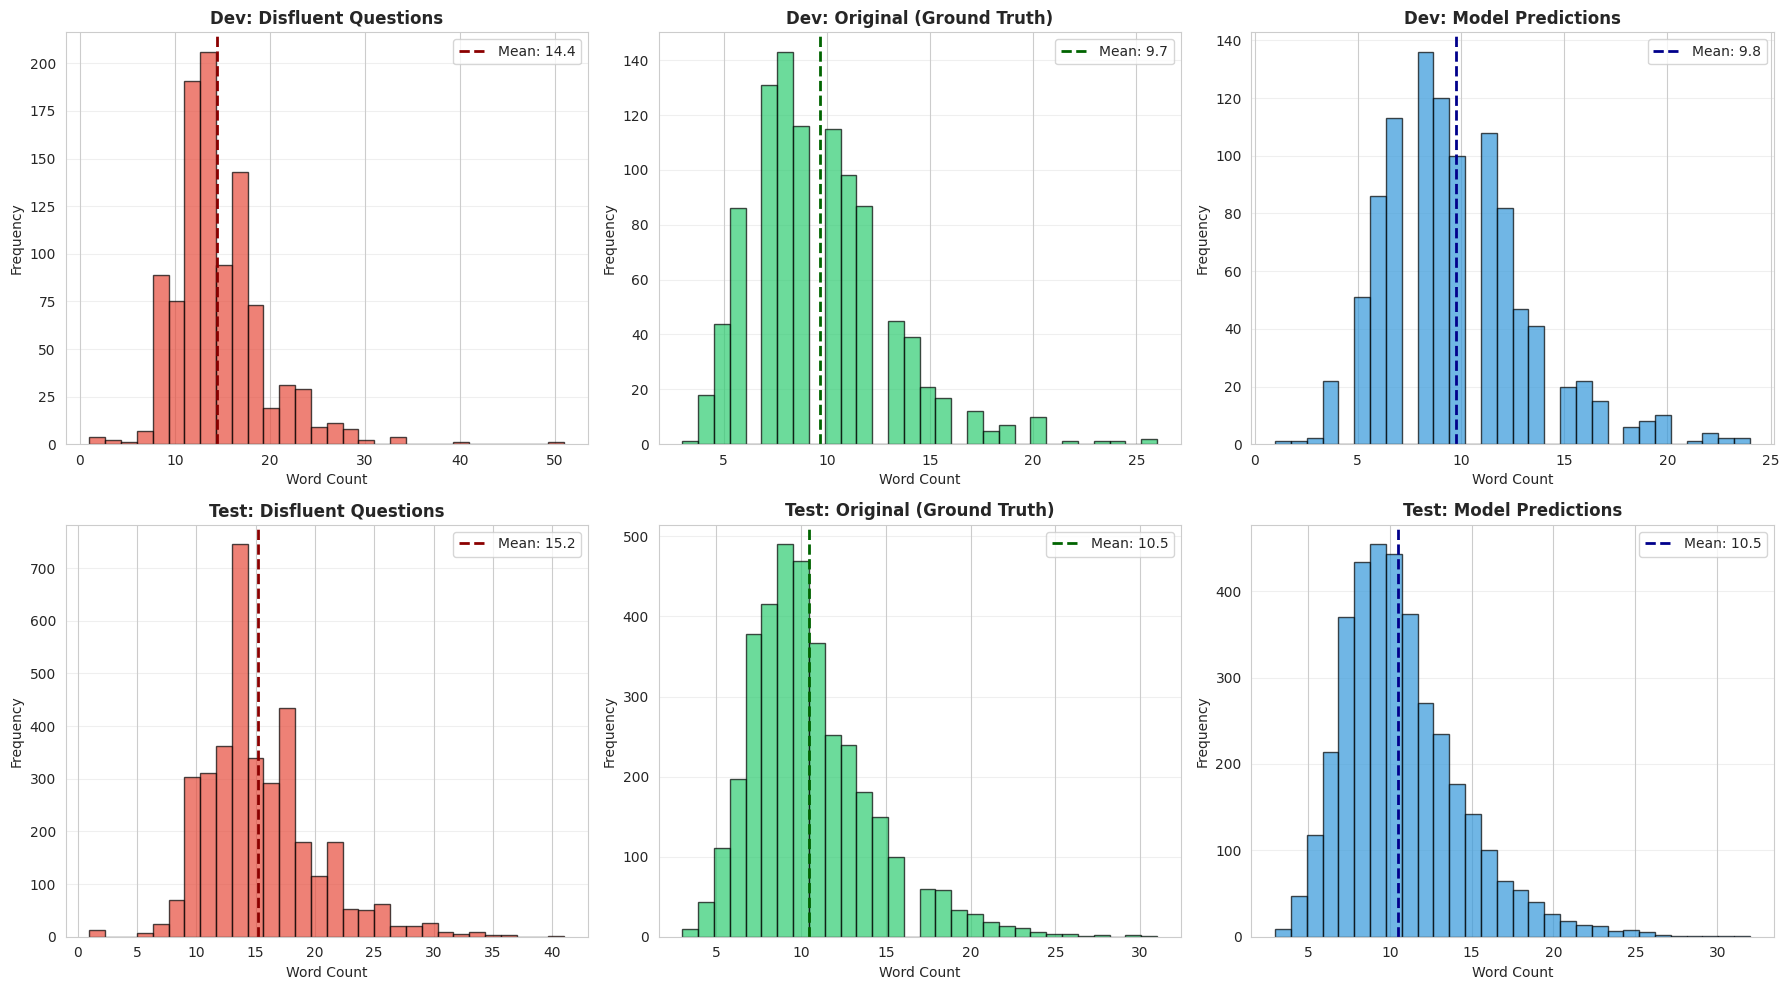


Word Length Statistics:

Dev Set:
  Disfluent - Mean: 14.41, Median: 14
  Original  - Mean: 9.65, Median: 9
  Predicted - Mean: 9.75, Median: 9

Test Set:
  Disfluent - Mean: 15.22, Median: 14
  Original  - Mean: 10.50, Median: 10
  Predicted - Mean: 10.52, Median: 10


In [24]:
# Compare word length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Dev Set
df_dev_eval['disfluent_len'] = df_dev_eval['disfluent'].str.split().str.len()
axes[0, 0].hist(df_dev_eval['disfluent_len'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_dev_eval['disfluent_len'].mean(), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {df_dev_eval["disfluent_len"].mean():.1f}')
axes[0, 0].set_title('Dev: Disfluent Questions', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Word Count', fontsize=10)
axes[0, 0].set_ylabel('Frequency', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].hist(df_dev_eval['orig_len'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df_dev_eval['orig_len'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                   label=f'Mean: {df_dev_eval["orig_len"].mean():.1f}')
axes[0, 1].set_title('Dev: Original (Ground Truth)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

axes[0, 2].hist(df_dev_eval['pred_len'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(df_dev_eval['pred_len'].mean(), color='darkblue', linestyle='--', linewidth=2,
                   label=f'Mean: {df_dev_eval["pred_len"].mean():.1f}')
axes[0, 2].set_title('Dev: Model Predictions', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Word Count', fontsize=10)
axes[0, 2].set_ylabel('Frequency', fontsize=10)
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)

# Test Set
df_test_eval['disfluent_len'] = df_test_eval['disfluent'].str.split().str.len()
axes[1, 0].hist(df_test_eval['disfluent_len'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(df_test_eval['disfluent_len'].mean(), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {df_test_eval["disfluent_len"].mean():.1f}')
axes[1, 0].set_title('Test: Disfluent Questions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Word Count', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].hist(df_test_eval['orig_len'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(df_test_eval['orig_len'].mean(), color='darkgreen', linestyle='--', linewidth=2,
                   label=f'Mean: {df_test_eval["orig_len"].mean():.1f}')
axes[1, 1].set_title('Test: Original (Ground Truth)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Word Count', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

axes[1, 2].hist(df_test_eval['pred_len'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 2].axvline(df_test_eval['pred_len'].mean(), color='darkblue', linestyle='--', linewidth=2,
                   label=f'Mean: {df_test_eval["pred_len"].mean():.1f}')
axes[1, 2].set_title('Test: Model Predictions', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Word Count', fontsize=10)
axes[1, 2].set_ylabel('Frequency', fontsize=10)
axes[1, 2].legend()
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWord Length Statistics:")
print("\nDev Set:")
print(f"  Disfluent - Mean: {df_dev_eval['disfluent_len'].mean():.2f}, Median: {df_dev_eval['disfluent_len'].median():.0f}")
print(f"  Original  - Mean: {df_dev_eval['orig_len'].mean():.2f}, Median: {df_dev_eval['orig_len'].median():.0f}")
print(f"  Predicted - Mean: {df_dev_eval['pred_len'].mean():.2f}, Median: {df_dev_eval['pred_len'].median():.0f}")

print("\nTest Set:")
print(f"  Disfluent - Mean: {df_test_eval['disfluent_len'].mean():.2f}, Median: {df_test_eval['disfluent_len'].median():.0f}")
print(f"  Original  - Mean: {df_test_eval['orig_len'].mean():.2f}, Median: {df_test_eval['orig_len'].median():.0f}")
print(f"  Predicted - Mean: {df_test_eval['pred_len'].mean():.2f}, Median: {df_test_eval['pred_len'].median():.0f}")

## Step 19: Save Model and Results

In [25]:
# Save LORA adapters
model_save_path = "lora_model_enhanced_full_dataset"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to: {model_save_path}")

# Save evaluation results
df_dev_eval.to_csv('dev_predictions_enhanced.csv', index=False)
df_test_eval.to_csv('test_predictions_enhanced.csv', index=False)
print(f"Predictions saved: dev_predictions_enhanced.csv, test_predictions_enhanced.csv")

# Save metrics
results_summary = {
    'config': CONFIG,
    'training_time_seconds': training_time,
    'dev_inference_time_seconds': dev_inference_time,
    'test_inference_time_seconds': test_inference_time,
    'dev_metrics': dev_metrics,
    'test_metrics': test_metrics,
    'trainable_parameters': trainable_params,
    'total_parameters': total_params,
}

with open('experiment_results_enhanced.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"Results summary saved: experiment_results_enhanced.json")

Model saved to: lora_model_enhanced_full_dataset
Predictions saved: dev_predictions_enhanced.csv, test_predictions_enhanced.csv
Results summary saved: experiment_results_enhanced.json


## Step 20: Final Summary Report

In [26]:
experiment_end_time = time.time()
total_experiment_time = experiment_end_time - experiment_start_time

print("="*80)
print(" "*20 + "EXPERIMENT 2 - ENHANCED SUMMARY")
print("="*80)

print("\nDATASET INFORMATION")
print("-" * 80)
print(f"Training samples: {TRAINING_ROWS:,}")
print(f"Dev samples: {len(df_dev):,}")
print(f"Test samples: {len(df_test):,}")

print("\nMODEL CONFIGURATION")
print("-" * 80)
print(f"Base Model: {CONFIG['model_name']}")
print(f"LORA Rank: {CONFIG['lora_r']}")
print(f"Trainable Parameters: {trainable_params:,} ({trainable_percentage:.2f}%)")
print(f"Total Parameters: {total_params:,}")

print("\nTIMING METRICS")
print("-" * 80)
print(f"Data Loading: {data_load_time:.2f}s")
print(f"Model Loading: {model_load_time:.2f}s")
print(f"Training: {training_time:.2f}s ({training_time/60:.2f} minutes)")
print(f"Dev Inference: {dev_inference_time:.2f}s ({dev_inference_time/len(df_dev):.3f}s per sample)")
print(f"Test Inference: {test_inference_time:.2f}s ({test_inference_time/len(df_test):.3f}s per sample)")
print(f"Total Experiment Time: {total_experiment_time:.2f}s ({total_experiment_time/60:.2f} minutes)")

print("\nDEV SET PERFORMANCE")
print("-" * 80)
print(f"BLEU Score: {dev_metrics['bleu']:.4f}")
print(f"ROUGE-1: {dev_metrics['rouge1']:.4f}")
print(f"ROUGE-2: {dev_metrics['rouge2']:.4f}")
print(f"ROUGE-L: {dev_metrics['rougeL']:.4f}")
print(f"Exact Match: {dev_metrics['exact_match']:.4f} ({int(dev_metrics['exact_match']*len(df_dev))}/{len(df_dev)})")
print(f"Word Error Rate: {dev_metrics['wer']:.4f}")
print(f"Character Error Rate: {dev_metrics['cer']:.4f}")

print("\nTEST SET PERFORMANCE")
print("-" * 80)
print(f"BLEU Score: {test_metrics['bleu']:.4f}")
print(f"ROUGE-1: {test_metrics['rouge1']:.4f}")
print(f"ROUGE-2: {test_metrics['rouge2']:.4f}")
print(f"ROUGE-L: {test_metrics['rougeL']:.4f}")
print(f"Exact Match: {test_metrics['exact_match']:.4f} ({int(test_metrics['exact_match']*len(df_test))}/{len(df_test)})")
print(f"Word Error Rate: {test_metrics['wer']:.4f}")
print(f"Character Error Rate: {test_metrics['cer']:.4f}")

print("\nSAVED ARTIFACTS")
print("-" * 80)
print(f"Model: {model_save_path}/")
print(f"Dev Predictions: dev_predictions_enhanced.csv")
print(f"Test Predictions: test_predictions_enhanced.csv")
print(f"Results Summary: experiment_results_enhanced.json")

print("\n" + "="*80)
print(" "*25 + "EXPERIMENT COMPLETE")
print("="*80)

                    EXPERIMENT 2 - ENHANCED SUMMARY

DATASET INFORMATION
--------------------------------------------------------------------------------
Training samples: 7,182
Dev samples: 1,000
Test samples: 3,643

MODEL CONFIGURATION
--------------------------------------------------------------------------------
Base Model: unsloth/Meta-Llama-3.1-8B
LORA Rank: 16
Trainable Parameters: 41,943,040 (0.90%)
Total Parameters: 4,670,623,744

TIMING METRICS
--------------------------------------------------------------------------------
Data Loading: 0.70s
Model Loading: 102.26s
Training: 4357.15s (72.62 minutes)
Dev Inference: 1155.64s (1.156s per sample)
Test Inference: 4403.80s (1.209s per sample)
Total Experiment Time: 11954.71s (199.25 minutes)

DEV SET PERFORMANCE
--------------------------------------------------------------------------------
BLEU Score: 0.8785
ROUGE-1: 0.9455
ROUGE-2: 0.9028
ROUGE-L: 0.9354
Exact Match: 0.6250 (625/1000)
Word Error Rate: 0.1174
Character Error Ra